<a href="https://colab.research.google.com/github/chiahao3/EM-scripts/blob/master/DIGIMAT_defect_finding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to identify point defects in atomic resolution STEM images with deep learning

Prepared by Chia-Hao Lee

Email: chiahao3@illinois.edu

In this notebook, you'll learn to do the followings:



1.   Import atomic resolution STEM images with point defects
2.   Practice common image processing techniques including background subtraction,thresholding, and Fourier filtering 
3.   Use deep learning models to identify defect positions

See more details of these contents from our [Nano Lett paper](https://pubs.acs.org/doi/10.1021/acs.nanolett.0c00269) :

"Deep Learning Enabled Strain Mapping of Single-Atom Defects in Two-Dimensional Transition Metal Dichalcogenides with Sub-Picometer Precision"

Or just visit our [Github repo](https://github.com/ClarkResearchGroup/stem-learning)



# Download files

In [1]:
### use zip files to download and extract the whole folders
download_link = "https://drive.google.com/file/d/1GNb9zsnzZOLyi_PvF2X6jydoc5sa6FGt"

!gdown --id 1GNb9zsnzZOLyi_PvF2X6jydoc5sa6FGt
!unzip -o resources.zip 

Downloading...
From: https://drive.google.com/uc?id=1GNb9zsnzZOLyi_PvF2X6jydoc5sa6FGt
To: /content/resources.zip
21.0MB [00:00, 67.1MB/s]
Archive:  resources.zip
  inflating: image_parse.py          
  inflating: model_2Te.json          
  inflating: model_SV.json           
  inflating: RR_2143 STEM 4.6 Mx HAADF_25.1pA_1024px_2.0us_Raw_Stack_16bit.tif  
  inflating: stitcher_py3.py         
  inflating: weights_2Te.h5          
  inflating: weights_SV.h5           


# Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from image_parse import *
from stitcher_py3 import * 

# Import STEM image

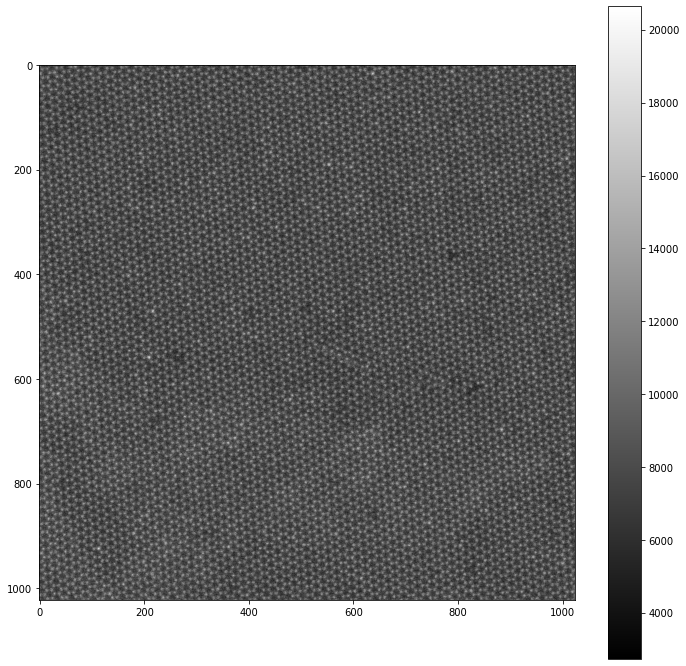

In [3]:
img = imread('RR_2143 STEM 4.6 Mx HAADF_25.1pA_1024px_2.0us_Raw_Stack_16bit.tif')
figsize = (12,12)
plt.figure(figsize=figsize)
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()

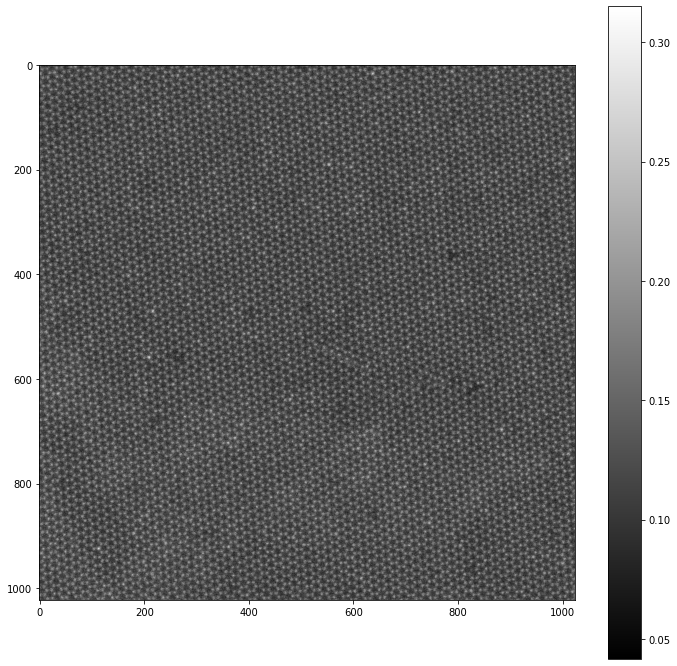

In [4]:
img_norm = img/65535

plt.figure(figsize=figsize)
plt.imshow(img_norm, cmap='gray')
plt.colorbar()
plt.show()

# Image processing with ImageJ

# Use deep learning to identify point defects

In [5]:
#Setup DL processing parameters
avg = True
(size_x, size_y, nb_classes) = (1024,1024,2)
(sx, sy) = (256, 256) #The stride of each cropped region
(lx, ly) = (256, 256)

model_list = ["model_2Te.json",
        "model_SV.json"]

weights_list = ["weights_2Te.h5",
         "weights_SV.h5"]

prefix_list = ["01_2Te",
        "02_SV"]


In [6]:
t0 = time.time()
'''
Load model and weights
'''
prediction_list=[]
for idx, model_fn in enumerate(model_list):
    
    model_weights_fn = weights_list[idx]
    
    print("loading model = ", model_fn)
    model = model_load(model_fn, model_weights_fn)
    
    '''
    Load image
    '''
    t_start = time.time()
    print("Processing STEM image")
    input_img = process_image(img_norm, standardize = True)
    
    print("cutting data")
    input_cuts = cut_data(input_img, lx, ly, (sx, sy))
    input_cuts = np.reshape(input_cuts, [-1, lx, ly, 1])
    num_cuts = len(input_cuts)

    print("predicting data")
    predictions=[get_avg_pred(model,cut) for cut in input_cuts] if avg else predict(model,input_cuts)
    predictions = np.reshape(np.array(predictions), [num_cuts, lx, ly, nb_classes])

    print("stitching data")
    as_stitched = stitch(size_x, size_y, sx, sy, predictions)
    arg_stitched = np.argmax(as_stitched, axis=2)

    output_prediction = np.uint8(arg_stitched*255)
    print("saving data")
    imsave(prefix_list[idx] + "_prediction.tif", output_prediction)
    t_end = time.time()
    print("Data saved! It cost ", t_end-t_start, "sec!\n")
    prediction_list.append(output_prediction)

tEnd = time.time()
print("All done, congratulations! It took ", tEnd-t0, "sec in total!")

loading model =  model_2Te.json
Processing STEM image
cutting data
predicting data
stitching data
saving data
Data saved! It cost  81.85910487174988 sec!

loading model =  model_SV.json
Processing STEM image
cutting data
predicting data
stitching data
saving data
Data saved! It cost  48.85382127761841 sec!

All done, congratulations! It took  137.37345671653748 sec in total!


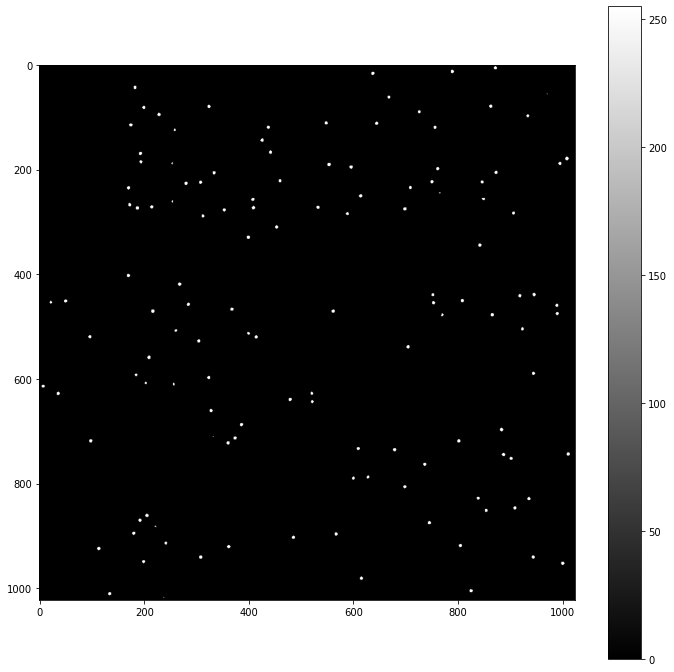

In [7]:
figsize = (12,12)
plt.figure(figsize=figsize)
plt.imshow(prediction_list[0], cmap='gray')
plt.colorbar()
plt.show()

# Get defect coordinates

In [8]:
def circle_detect(img):
  from skimage.filters import sobel
  from skimage.measure import regionprops
  from skimage.morphology import watershed
  from scipy import ndimage as ndi

  location_list = []
  (width, height) = np.shape(img)
 
  label_objects, nb_labels = ndi.label(img)
  props = regionprops(label_objects)

  ori_array = np.array(img)
  for p in props:
    if p.area >= 10:
      c_y, c_x = p.centroid
      location_list.append((int(c_y), int(c_x)))
  return location_list

In [9]:
location_list_2Te = circle_detect(prediction_list[0])
location_list_SV = circle_detect(prediction_list[1])
print("2Te, ", np.shape(location_list_2Te))
print("SV, ", np.shape(location_list_SV))

2Te,  (123, 2)
SV,  (278, 2)


In [10]:
map_2Te = np.zeros_like(img)
for pos in location_list_2Te:
  #print(pos)
  map_2Te[pos] = 65535
imsave("map_2Te.tif", map_2Te)

map_SV = np.zeros_like(img)
for pos in location_list_SV:
  #print(pos)
  map_SV[pos] = 65535
imsave("map_SV.tif", map_SV)

# Crop defects

In [11]:
def make_mask_from_positions(position_list, radius, data_shape):
    def make_square_mask(centerX, centerY, imageSizeX, imageSizeY, radius):
        y, x = np.ogrid[-centerX:imageSizeX-centerX, -centerY:imageSizeY-centerY]
        mask = np.logical_and(np.abs(y)<=radius, np.abs(x)<=radius)

        return(mask)
    
    """
    Parameters
    ----------
    position_list : list of list
        [[x0, y0], [x1, y1]]
    radius_list : list
    data_shape : tuple

    Examples
    --------
    >>> from atomap.atom_finding_refining import _make_mask_from_positions
    >>> pos = [[10, 20], [25, 10]]
    >>> radius = [2, 1]
    >>> mask = _make_mask_from_positions(pos, radius, (40, 40))
    """
    mask = np.zeros(data_shape, dtype=np.bool)
    for position in position_list:
        mask += make_square_mask(
                position[0], position[1],
                data_shape[0], data_shape[1],
                radius)
    return(mask)

def num_defects_in_window(center_list, l):
    num_defects_list = []

    for (i, j) in center_list:
        x_start = i - l//2 
        x_end   = i + l//2 + l%2 
        y_start = j - l//2
        y_end   = j + l//2 + l%2
        num_defects = sum(map(lambda r: x_start < r[0] < x_end and y_start < r[1] < y_end, list(center_list)))
        num_defects_list.append(num_defects)
    return num_defects_list

def crop_Image(image, center_list, size, offset):
    img_list=[]
    crop_positions_list=[]
    for (x, y) in center_list:
        x_start = x - size[0]//2 + offset[0]
        x_end   = x + size[0]//2 + offset[0] + size[0]%2 
        y_start = y - size[1]//2 + offset[1]
        y_end   = y + size[1]//2 + offset[1] + size[1]%2
        if 0 <= x_start < x_end < np.shape(image)[0] and 0 <= y_start < y_end < np.shape(image)[1]: 
            img_list.append(image[x_start:x_end, y_start:y_end])
            crop_positions_list.append((x,y))
    return img_list, crop_positions_list

In [12]:
###Setup the elimination parameter
#Note: This parameter is to eliminate the defect sites that are around other types of influencing defect(vacancy)
#So the larger the parameter, the farther vacancy is included in the calculation of masking.

defect_mode = 'defect'
if defect_mode == 'defect':
    elimination_radius = 32 #radius of the box, so the window size will be (2 * eliminator_radius)^2, 64*64 will be 4*4 unit cells
elif defect_mode == 'regular': #Regular
    elimination_radius = 64 

print(elimination_radius)
    
NN_window = elimination_radius*2
crop_size = [128,128]
offset = [0,0]
total_defect_count = 0
total_crop_count = 0
count = 0
total_img_list=[]

#Importing images
quant_img = img
defect_img = map_2Te 
eliminate_map_img = map_SV


#Find defect positions and mask positions
defect_positions = np.transpose(np.nonzero(defect_img)) #(Row,column)
mask_positions = np.transpose(np.nonzero(eliminate_map_img)) #(Row,column)
print('Find ', len(defect_positions), 'defects from original defect map')
print('Find ', len(mask_positions), 'defects from eliminate map ')

#Apply mask and find defect positions again
mask = ~make_mask_from_positions(mask_positions, elimination_radius, np.shape(defect_img))
elim_defect_positions = np.transpose(np.nonzero(mask*defect_img)) #(Row,column)
print('Find ', len(elim_defect_positions), 'defects after elimination from elimination map')

#Process the elim_defect_list and remove those who has NN in the specified window.
num_defects= num_defects_in_window(elim_defect_positions, NN_window)
    
#Get the final defect positions by checking NN numbers
final_defect_positions=[]
for num in range(len(num_defects)):
    if defect_mode =='regular': #For Regular case there's no need for NN elimination
        if num_defects[num] >= 1:
            final_defect_positions.append(elim_defect_positions[num])
    else:
        if num_defects[num] == 1:
            final_defect_positions.append(elim_defect_positions[num])

total_defect_count += len(final_defect_positions)
print('Find ', len(final_defect_positions), 'defects after elimination from NN')

#Crop final images
final_img_list = []
crop_positions_list = []
final_img_list, crop_positions_list = crop_Image(quant_img, final_defect_positions, crop_size, offset)
print('Crop', len(final_img_list), 'defects after considering image edges')
total_crop_count += len(final_img_list)


#Save final image stack for each image
for i in range(len(final_img_list)):
    count += 1
    total_img_list.append(final_img_list[i])
#total_img_list = All the image stacks together
print('\nTotal defects number are ', total_defect_count)    
print('\nElimination radius = ', elimination_radius)
print('NN_window = ', NN_window)
print('Total cropped images number are ', total_crop_count) 

#Save the final stack
output_fn = defect_mode + '_stack_'+str(len(total_img_list)).zfill(5)+'_NN'+str(NN_window)+'.tif'
print(output_fn)
imsave(output_fn, np.uint16(np.array(total_img_list)))

32
Find  123 defects from original defect map
Find  278 defects from eliminate map 
Find  39 defects after elimination from elimination map
Find  27 defects after elimination from NN
Crop 23 defects after considering image edges

Total defects number are  27

Elimination radius =  32
NN_window =  64
Total cropped images number are  23
defect_stack_00023_NN64.tif


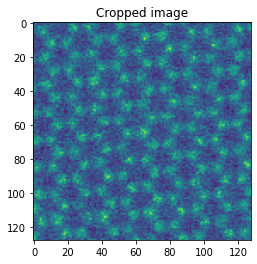

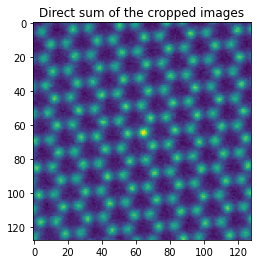

In [13]:
#Check cropped images
plt.figure()
plt.title('Cropped image')
plt.imshow(total_img_list[0])
plt.show()

#Check direct sum image
plt.figure()
plt.title('Direct sum of the cropped images')
plt.imshow(np.sum(total_img_list, axis=0))
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


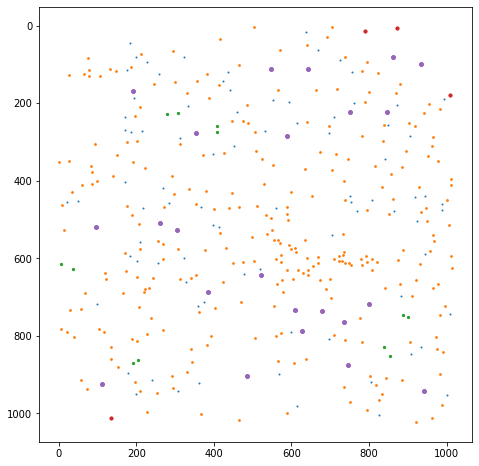

In [14]:
#Sanity check of the defect position at each step
(x,y)=zip(*defect_positions) #Original defect position
(x_d,y_d)=zip(*mask_positions) #Mask coming from nearby vacancies
(x_e,y_e)=zip(*elim_defect_positions) #Remained positions after the above masking
(x_f,y_f)=zip(*final_defect_positions) #Final positions after NN removal
(x_c, y_c)=zip(*crop_positions_list)#Crop positions list

plt.figure(figsize=(8,8))
plt.scatter(y,x,s=1)      #Blue, original defect position
plt.scatter(y_d,x_d, s=3) #Orange, nearby defects
plt.scatter(y_e,x_e,s=5)  #Green
plt.scatter(y_f,x_f,s=10) #Red
plt.scatter(y_c,x_c,s=15) #Purple, final cropping position

plt.gca().invert_yaxis()
plt.axes().set_aspect('equal')
plt.show()